# Predicting Customer Churn in Subscription Services

Subscription-based businesses, such as streaming platforms, telecommunications providers, and SaaS companies (Google, Microsoft, Salesforce, etc.), rely heavily on maintaining a stable customer base to sustain growth and profitability. One of the biggest challenges these businesses face is customer churn, where users cancel their subscriptions and stop using the service. Understanding why customers churn and predicting which customers are likely to leave can provide valuable insights for designing targeted retention strategies. The goal is to build a Random Forest model to predict whether a customer is likely to churn based on their historical usage, demographics, and account activity.

## The Data

The data will be pulled from a fictitious company called Telco. The dataset generally contains information about customer demographics, account information, usage patterns, and services subscribed to. By analyzing this data, the goal is to identify the factors that contribute to customer churn and develop strategies to retain customers.

#### Load the Data

In [1]:
import pandas as pd
demographics = pd.read_excel('/content/drive/MyDrive/Telecommunications_Industry/Telco_customer_churn_demographics.xlsx')
location = pd.read_excel('/content/drive/MyDrive/Telecommunications_Industry/Telco_customer_churn_location.xlsx')
services = pd.read_excel('/content/drive/MyDrive/Telecommunications_Industry/Telco_customer_churn_services.xlsx')
status = pd.read_excel('/content/drive/MyDrive/Telecommunications_Industry/Telco_customer_churn_status.xlsx')

#### Merge the Datasets

In [2]:
# merge the datasets on Customer ID
churn_df = demographics.merge(location, on='Customer ID', how='inner')
churn_df = churn_df.merge(services, on='Customer ID', how='inner')
status = status.rename(columns={'Count': 'Status_Count'})  #had to rename Count column in status table to avoid duplicate columns
churn_df = churn_df.merge(status, on='Customer ID', how='inner')

In [3]:
#copy original merged dataset for visualization purposes
df = churn_df.copy()

In [4]:
df['Internet Type'] = df['Internet Type'].fillna('No Service')
print(df.isnull().sum()) # check for missing values

Customer ID                             0
Count_x                                 0
Gender                                  0
Age                                     0
Under 30                                0
Senior Citizen                          0
Married                                 0
Dependents                              0
Number of Dependents                    0
Location ID                             0
Count_y                                 0
Country                                 0
State                                   0
City                                    0
Zip Code                                0
Lat Long                                0
Latitude                                0
Longitude                               0
Service ID                              0
Count                                   0
Quarter_x                               0
Referred a Friend                       0
Number of Referrals                     0
Tenure in Months                  

#### Quick Look At the Data

In [ ]:
churn_df.head()

,Customer ID,Count_x,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Location ID,...,Status_Count,Quarter_y,Satisfaction Score,Customer Status,Churn Label,Churn Value,Churn Score,CLTV,Churn Category,Churn Reason
0,8779-QRDMV,1,Male,78,No,Yes,No,No,0,OXCZEW7397,...,1,Q3,3,Churned,Yes,1,91,5433,Competitor,Competitor offered more data
1,7495-OOKFY,1,Female,74,No,Yes,Yes,Yes,1,FCCECI8494,...,1,Q3,3,Churned,Yes,1,69,5302,Competitor,Competitor made better offer
2,1658-BYGOY,1,Male,71,No,Yes,No,Yes,3,HEHUQY7254,...,1,Q3,2,Churned,Yes,1,81,3179,Competitor,Competitor made better offer
3,4598-XLKNJ,1,Female,78,No,Yes,Yes,Yes,1,WIUHRF2613,...,1,Q3,2,Churned,Yes,1,88,5337,Dissatisfaction,Limited range of services
4,4846-WHAFZ,1,Female,80,No,Yes,Yes,Yes,1,CFEZBF4415,...,1,Q3,2,Churned,Yes,1,67,2793,Price,Extra data charges


The target variable will be Churn Value.

In [ ]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 59 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Count_x                            7043 non-null   int64  
 2   Gender                             7043 non-null   object 
 3   Age                                7043 non-null   int64  
 4   Under 30                           7043 non-null   object 
 5   Senior Citizen                     7043 non-null   object 
 6   Married                            7043 non-null   object 
 7   Dependents                         7043 non-null   object 
 8   Number of Dependents               7043 non-null   int64  
 9   Location ID                        7043 non-null   object 
 10  Count_y                            7043 non-null   int64  
 11  Country                            7043 non-null   objec

In [ ]:
print(churn_df.describe())

       Count_x          Age  Number of Dependents  Count_y      Zip Code  \
count   7043.0  7043.000000           7043.000000   7043.0   7043.000000   
mean       1.0    46.509726              0.468692      1.0  93486.071134   
std        0.0    16.750352              0.962802      0.0   1856.768045   
min        1.0    19.000000              0.000000      1.0  90001.000000   
25%        1.0    32.000000              0.000000      1.0  92101.000000   
50%        1.0    46.000000              0.000000      1.0  93518.000000   
75%        1.0    60.000000              0.000000      1.0  95329.000000   
max        1.0    80.000000              9.000000      1.0  96150.000000   

          Latitude    Longitude   Count  Number of Referrals  \
count  7043.000000  7043.000000  7043.0          7043.000000   
mean     36.197455  -119.756684     1.0             1.951867   
std       2.468929     2.154425     0.0             3.001199   
min      32.555828  -124.301372     1.0             0.00000

#### Data Cleaning/ Feature Selection

In [5]:
# select features
selected_features = [
    'Age', 'Gender', 'Senior Citizen', 'Married', 'Dependents', 'Number of Dependents',
    'Tenure in Months', 'Phone Service', 'Multiple Lines', 'Internet Service',
    'Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan',
    'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music',
    'Unlimited Data', 'Monthly Charge', 'Total Charges', 'Payment Method', 'Contract',
    'Paperless Billing', 'Churn Value'
]
churn_df = churn_df[selected_features]
churn_df.head()

,Age,Gender,Senior Citizen,Married,Dependents,Number of Dependents,Tenure in Months,Phone Service,Multiple Lines,Internet Service,...,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Monthly Charge,Total Charges,Payment Method,Contract,Paperless Billing,Churn Value
0,78,Male,Yes,No,No,0,1,No,No,Yes,...,No,Yes,No,No,39.65,39.65,Bank Withdrawal,Month-to-Month,Yes,1
1,74,Female,Yes,Yes,Yes,1,8,Yes,Yes,Yes,...,No,No,No,Yes,80.65,633.30,Credit Card,Month-to-Month,Yes,1
2,71,Male,Yes,No,Yes,3,18,Yes,Yes,Yes,...,Yes,Yes,Yes,Yes,95.45,1752.55,Bank Withdrawal,Month-to-Month,Yes,1
3,78,Female,Yes,Yes,Yes,1,25,Yes,No,Yes,...,Yes,Yes,No,Yes,98.50,2514.50,Bank Withdrawal,Month-to-Month,Yes,1
4,80,Female,Yes,Yes,Yes,1,37,Yes,Yes,Yes,...,No,No,No,Yes,76.50,2868.15,Bank Withdrawal,Month-to-Month,Yes,1


In [ ]:
print(churn_df.isnull().sum()) # check for missing values

Age                          0
Gender                       0
Senior Citizen               0
Married                      0
Dependents                   0
Number of Dependents         0
Tenure in Months             0
Phone Service                0
Multiple Lines               0
Internet Service             0
Internet Type             1526
Online Security              0
Online Backup                0
Device Protection Plan       0
Premium Tech Support         0
Streaming TV                 0
Streaming Movies             0
Streaming Music              0
Unlimited Data               0
Monthly Charge               0
Total Charges                0
Payment Method               0
Contract                     0
Paperless Billing            0
Churn Value                  0
dtype: int64


In [ ]:
churn_df['Internet Service'].value_counts()

,count
Internet Service,
Yes,5517
No,1526


In [6]:
#Internet Type is null when there is no internet service, replace null with "No Service"
churn_df['Internet Type'] = churn_df['Internet Type'].fillna('No Service')
print(churn_df.isnull().sum()) # check for missing values

Age                       0
Gender                    0
Senior Citizen            0
Married                   0
Dependents                0
Number of Dependents      0
Tenure in Months          0
Phone Service             0
Multiple Lines            0
Internet Service          0
Internet Type             0
Online Security           0
Online Backup             0
Device Protection Plan    0
Premium Tech Support      0
Streaming TV              0
Streaming Movies          0
Streaming Music           0
Unlimited Data            0
Monthly Charge            0
Total Charges             0
Payment Method            0
Contract                  0
Paperless Billing         0
Churn Value               0
dtype: int64


In [ ]:
# check for duplicates
print(churn_df.duplicated().sum())
# remove duplicates
churn_df = churn_df.drop_duplicates()

0


#### Feature Engineering

In [7]:
# encode categorical variables
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_columns = churn_df.select_dtypes(include=['object']).columns
encoded_df = pd.DataFrame(onehot_encoder.fit_transform(churn_df[categorical_columns]))
encoded_df.columns = onehot_encoder.get_feature_names_out(categorical_columns)
churn_df_encoded = pd.concat([churn_df.drop(columns=categorical_columns), encoded_df], axis=1)


churn_df_encoded.head()



,Age,Number of Dependents,Tenure in Months,Monthly Charge,Total Charges,Churn Value,Gender_Male,Senior Citizen_Yes,Married_Yes,Dependents_Yes,...,Premium Tech Support_Yes,Streaming TV_Yes,Streaming Movies_Yes,Streaming Music_Yes,Unlimited Data_Yes,Payment Method_Credit Card,Payment Method_Mailed Check,Contract_One Year,Contract_Two Year,Paperless Billing_Yes
0,78,0,1,39.65,39.65,1,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,74,1,8,80.65,633.30,1,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,71,3,18,95.45,1752.55,1,1.0,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,78,1,25,98.50,2514.50,1,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,80,1,37,76.50,2868.15,1,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# features (X) and target variable (y)
X = churn_df_encoded.drop(columns=['Churn Value'])
y = churn_df_encoded['Churn Value']

In [ ]:
# train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Build and Train Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

####Evaluate the Model

Accuracy: 0.8168914123491838
Precision: 0.7151515151515152
Recall: 0.59
F1 Score: 0.6465753424657534
AUC: 0.8693471258671952
Confusion Matrix:
 [[915  94]
 [164 236]]


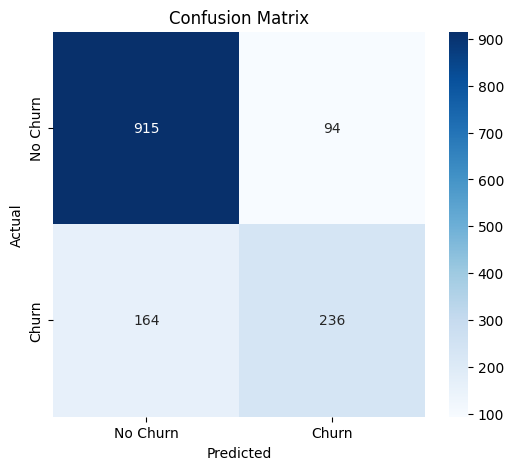


Classification Report:

              precision    recall  f1-score   support

    No Churn       0.85      0.91      0.88      1009
       Churn       0.72      0.59      0.65       400

    accuracy                           0.82      1409
   macro avg       0.78      0.75      0.76      1409
weighted avg       0.81      0.82      0.81      1409



In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# make predictions
y_pred = rf_model.predict(X_test)

# predict probabilities for AUC calculation
y_prob = rf_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

recall = recall_score(y_test, y_pred)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

auc = roc_auc_score(y_test, y_prob)
print("AUC:", auc)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
# visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=["No Churn", "Churn"]))


The Random Forest model achieved an accuracy of 81.7%, indicating that it correctly predicted churn for the majority of the test data. The precision of 71.5% shows that when the model predicts churn, it is correct about 71.5% of the time. The recall of 59.0% indicates that the model correctly identifies 59% of all actual churn cases, leaving room for improvement in detecting more true positives. The F1 score of 64.7% balances precision and recall, providing a reasonable measure of the model’s overall effectiveness. The AUC of 0.87 reflects strong discriminatory power, meaning the model is good at distinguishing between customers who churn and those who do not. Though the model performs fairly well, it is not performing as expected. The success criteria is an accuracy of 85% and and F1 score of at least 0.8. This is indicative that the model can be improved further.

#### Improve the Model

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer

# K-Fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# define the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# define the hyperparameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# perform GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=kf, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X, y)

# get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# output the best hyperparameters and best score
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")

# get the best model from grid search
best_rf_model = grid_search.best_estimator_




Fitting 5 folds for each of 648 candidates, totalling 3240 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1080 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
734 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py

Best Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Score: 0.8343046325569391


#### Evaluate improved model

Cross-Validation Accuracy for each fold: [0.83321505 0.82398864 0.83818311 0.83167614 0.84446023]
Average Cross-Validation Accuracy: 0.8343046325569391
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.91      5174
           1       0.80      0.67      0.73      1869

    accuracy                           0.87      7043
   macro avg       0.84      0.80      0.82      7043
weighted avg       0.86      0.87      0.86      7043

Confusion Matrix:
 [[4865  309]
 [ 625 1244]]


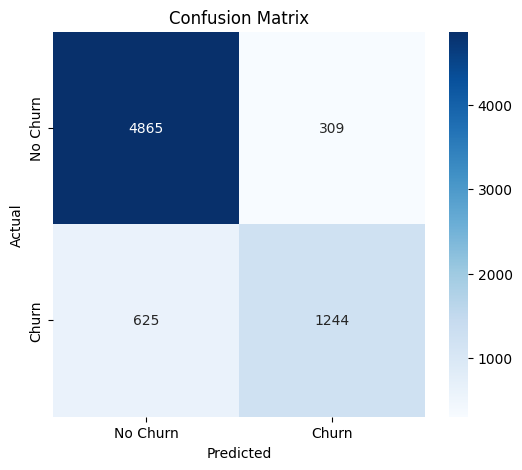

F1 Score: 0.7270601987142022
Precision: 0.8010302640051513
Recall: 0.6655965757089353
Accuracy: 0.8673860570779497
AUC: 0.9373771355025943


In [ ]:
# train the model
best_rf_model.fit(X, y)

# evaluate the model on cross-validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_rf_model, X, y, cv=kf, scoring='accuracy')

print("Cross-Validation Accuracy for each fold:", cv_scores)
print("Average Cross-Validation Accuracy:", cv_scores.mean())


#make predictions
y_pred = best_rf_model.predict(X)

# evaluation metrics
print("Classification Report:\n", classification_report(y, y_pred))

print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
# visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

f1 = f1_score(y, y_pred)
print(f"F1 Score: {f1}")

precision = precision_score(y, y_pred)
print(f"Precision: {precision}")

recall = recall_score(y, y_pred)
print(f"Recall: {recall}")

accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy}")

auc = roc_auc_score(y, best_rf_model.predict_proba(X)[:, 1])
print(f"AUC: {auc}")


In contrast to the first model, the updated Random Forest model shows significant improvement across several key performance indicators. The accuracy has increased to 86.7% from 81.7%, demonstrating that the model now correctly predicts churn for a larger proportion of the test data. The precision has improved substantially from 71.5% to 80.1%, meaning the model is now more reliable in predicting churners, with fewer false positives. The recall has also risen from 59.0% to 66.6%, meaning the model is capturing more actual churn cases, though there is still room for further improvement in detecting all true positives. The F1 score has increased from 64.7% to 72.7%, reflecting a better balance between precision and recall, and bringing the model closer to the desired benchmark of 0.8. Finally, the AUC has shown a notable improvement from 0.87 to 0.94, indicating a much stronger ability to distinguish between customers who churn and those who do not. Overall, these improvements suggest that the model is now performing closer to the success criteria of an accuracy above 85% and an F1 score of at least 0.8, with potential for further optimization to achieve even higher performance.

### Data Insights

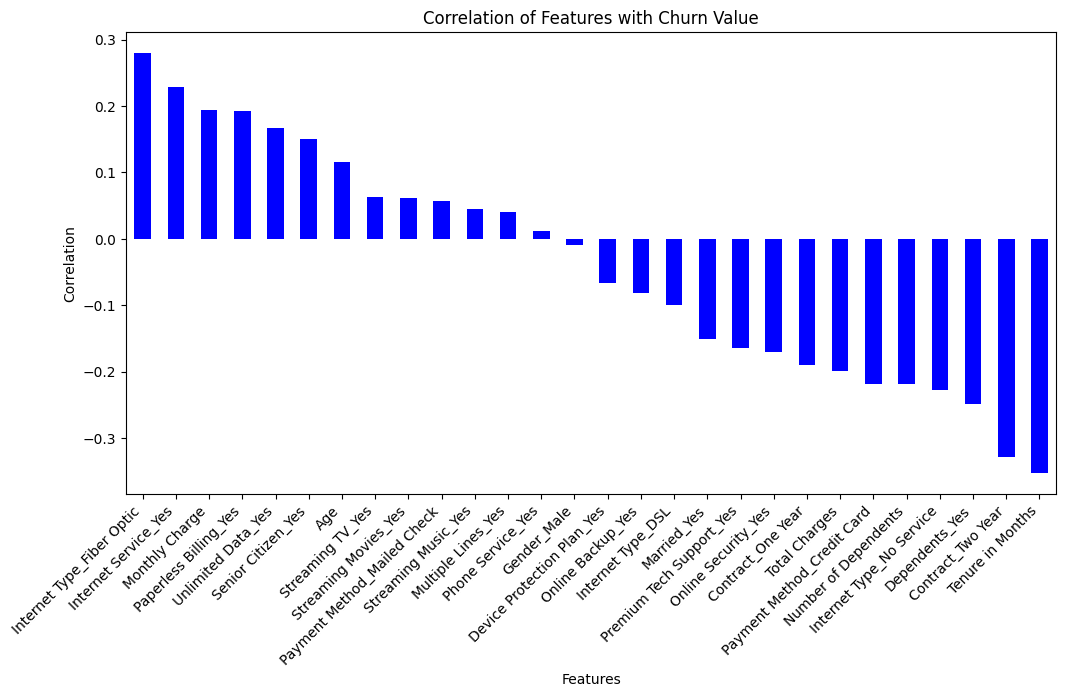

In [8]:
# correlation matrix
import matplotlib.pyplot as plt
# calculate correlations with Churn Value
correlation_with_target = churn_df_encoded.corr()['Churn Value'].drop('Churn Value')

plt.figure(figsize=(12, 6))
correlation_with_target.sort_values(ascending=False).plot(kind='bar', color='blue')
plt.title("Correlation of Features with Churn Value")
plt.xlabel("Features")
plt.ylabel("Correlation")
plt.xticks(rotation=45, ha='right')
plt.show()

Features with high positive correlation contribute to churn, whereas features with high negative correlation reduce churn liklihood.

Based on the correlation matrix, several actionable insights can help reduce churn. Customers with longer tenure and more dependents tend to churn less, suggesting that retaining customers early on and offering family-friendly plans could improve loyalty. The positive correlation between churn and monthly charges indicates that pricing strategies may need adjustment, such as offering discounts or value-added services to higher-paying customers. Customers with Fiber Optic internet are less likely to churn, so prioritizing upgrades from DSL or No Service to Fiber Optic could reduce churn. Additionally, encouraging customers to commit to two-year contracts and switch to automated payment methods like credit cards could enhance retention. Offering essential services like Online Security, Device Protection, and Premium Tech Support can also reduce churn, as these services show a negative correlation with churn. Personalized offers based on customer demographics, like senior citizen discounts or family-oriented packages, can help maintain customer satisfaction and prevent churn. By optimizing these factors, the company can improve customer retention and reduce the risk of churn.

<ipython-input-58-659dd2aca6c7>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_rate_age = churn_df.groupby('Age Group')['Churn Value'].mean()
<ipython-input-58-659dd2aca6c7>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate_age.index, y=churn_rate_age.values, palette='Blues_d')


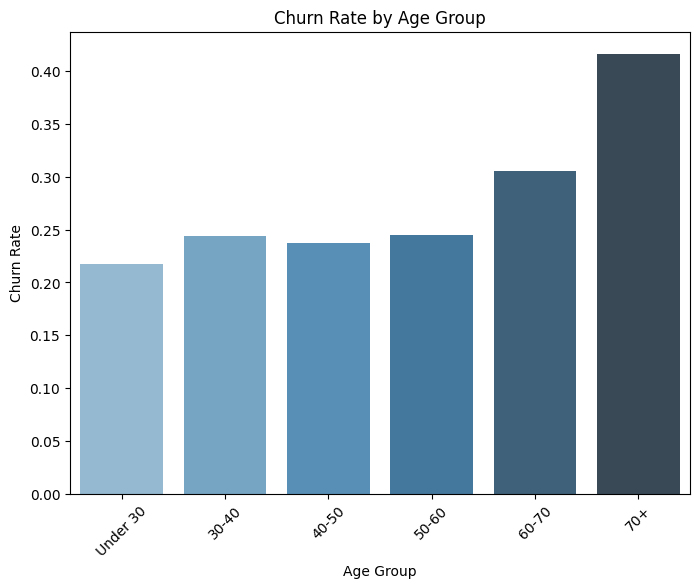

In [ ]:
import seaborn as sns

# create age groups
bins = [0, 30, 40, 50, 60, 70, 100]  # Age ranges
labels = ['Under 30', '30-40', '40-50', '50-60', '60-70', '70+']
churn_df['Age Group'] = pd.cut(churn_df['Age'], bins=bins, labels=labels, right=False)

# calculate churn rate by age group
churn_rate_age = churn_df.groupby('Age Group')['Churn Value'].mean()

plt.figure(figsize=(8, 6))
sns.barplot(x=churn_rate_age.index, y=churn_rate_age.values, palette='Blues_d')
plt.title('Churn Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.show()

The higher churn rate observed among the 70+ age group suggests that targeted strategies are needed to improve retention in this demographic. Offering personalized customer support, such as dedicated assistance or simplified service options, can help address their unique needs. Additionally, creating loyalty programs and providing senior-focused bundles or offers related to health and wellness could increase their satisfaction and loyalty. By tailoring offerings to this group’s specific preferences and challenges, the company can enhance retention and reduce churn.

<ipython-input-10-0323c4871395>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_rate_by_tenure = churn_df.groupby('Tenure Category')['Churn Value'].mean()
<ipython-input-10-0323c4871395>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate_by_tenure.index, y=churn_rate_by_tenure.values, palette='Blues_d')


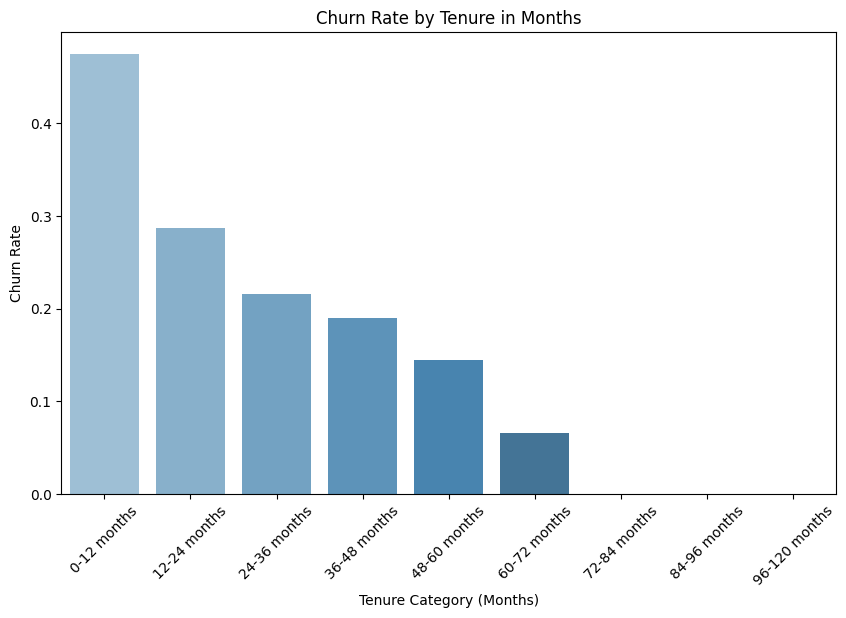

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))

# creating bins for tenure in months
bins = [0, 12, 24, 36, 48, 60, 72, 84, 96, 120]
labels = ['0-12 months', '12-24 months', '24-36 months', '36-48 months', '48-60 months', '60-72 months', '72-84 months', '84-96 months', '96-120 months']
churn_df['Tenure Category'] = pd.cut(churn_df['Tenure in Months'], bins=bins, labels=labels)

churn_rate_by_tenure = churn_df.groupby('Tenure Category')['Churn Value'].mean()

sns.barplot(x=churn_rate_by_tenure.index, y=churn_rate_by_tenure.values, palette='Blues_d')
plt.title('Churn Rate by Tenure in Months')
plt.xlabel('Tenure Category (Months)')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.show()

The analysis reveals that customers with shorter tenure, particularly those within the 0-12 months range, have a significantly higher churn rate compared to those with longer tenure. This indicates that new customers are more prone to leaving early, which could be attributed to factors like poor onboarding experiences, unmet expectations, or dissatisfaction with the service. To address this, the company should focus on improving the onboarding process, offering targeted promotions or incentives for early-stage customers, and gathering feedback to identify areas of improvement.

<ipython-input-66-b51f79cfdb25>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_rate_by_monthly_charge = churn_df.groupby('Monthly Charge Category')['Churn Value'].mean()
<ipython-input-66-b51f79cfdb25>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate_by_monthly_charge.index, y=churn_rate_by_monthly_charge.values, palette="Blues_d")


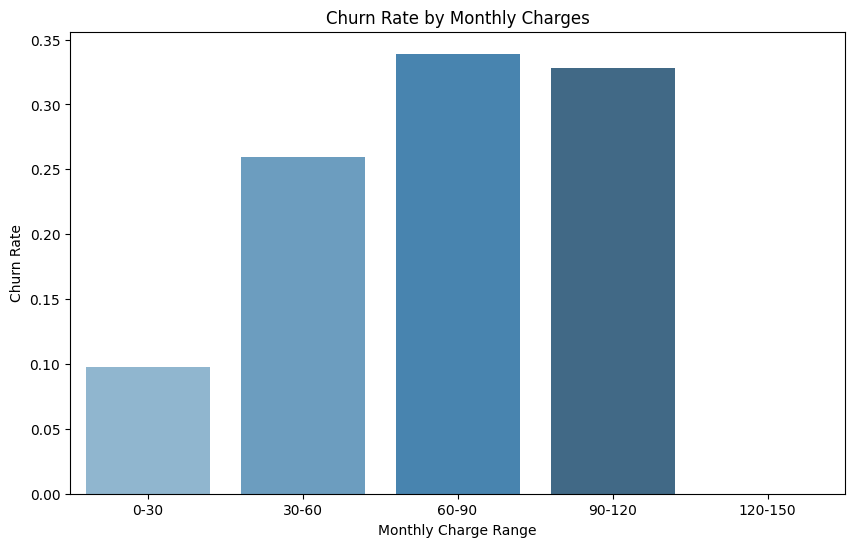

Monthly Charge Category
0-30       0.098004
30-60      0.259289
60-90      0.339061
90-120     0.327775
120-150         NaN
Name: Churn Value, dtype: float64


In [ ]:
# bin the Monthly Charges
bins = [0, 30, 60, 90, 120,  float('inf')]
labels = ['0-30', '30-60', '60-90', '90-120', '120-150']

churn_df['Monthly Charge Category'] = pd.cut(churn_df['Monthly Charge'], bins=bins, labels=labels)

churn_rate_by_monthly_charge = churn_df.groupby('Monthly Charge Category')['Churn Value'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=churn_rate_by_monthly_charge.index, y=churn_rate_by_monthly_charge.values, palette="Blues_d")
plt.xlabel("Monthly Charge Range")
plt.ylabel("Churn Rate")
plt.title("Churn Rate by Monthly Charges")
plt.show()

# Display churn rate by monthly charge category
print(churn_rate_by_monthly_charge)

The churn rate analysis by monthly charge shows that as customers' monthly payments increase, the likelihood of them leaving also increases. Customers paying between 60 and 90 dollars have the highest churn rate at 33.9%, followed by those paying between 90 and 120 dollars at 32.8%. Customers paying 30 to 60 dollars also have a high churn rate at 25.9%. However, customers paying less than 30 dollars have a much lower churn rate of 9.8%, meaning they are less likely to leave. This suggests that customers with higher bills might not feel they are getting enough value for their money, which could be a reason for leaving. To reduce churn, the company might want to improve offerings or provide special incentives for higher-paying customers.

<ipython-input-11-7d43c0d5f103>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_reason_counts.index, y=churn_reason_counts.values, palette='Blues_d')


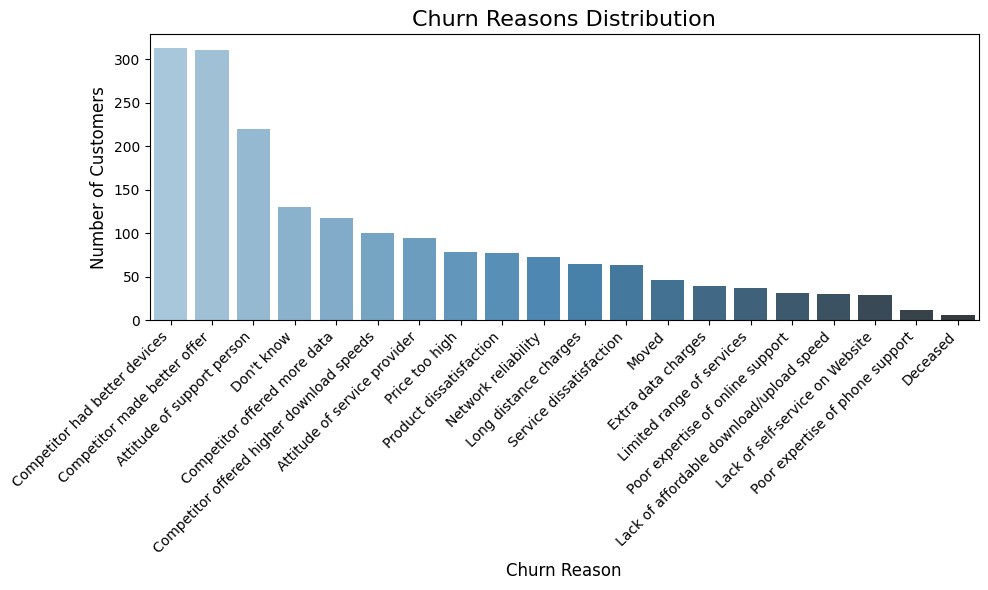

In [ ]:
# drop null values
df_clean = df.dropna(subset=['Churn Reason'])

# count the frequency of each churn reason
churn_reason_counts = df_clean['Churn Reason'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=churn_reason_counts.index, y=churn_reason_counts.values, palette='Blues_d')
plt.xticks(rotation=45, ha='right')

plt.title('Churn Reasons Distribution', fontsize=16)
plt.xlabel('Churn Reason', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)

plt.tight_layout()
plt.show()

The churn reasons reveal key factors contributing to customer churn. The most common reasons are related to competitors, with many customers leaving because they perceive better offers or devices from other companies. Customer service issues, such as dissatisfaction with the attitude of support or the service provider, also play a significant role in churn. Price-related concerns, including high costs and extra data charges, are other common drivers, indicating that customers may be leaving due to perceived poor value for the service. Additionally, issues related to network reliability, limited services, and slow speeds contribute to customer dissatisfaction. Rare reasons such as a customer's passing also appear, but they are less frequent. These insights highlight areas for improvement, such as enhancing the competitive offer, improving customer service, revising pricing strategies, and ensuring more reliable and efficient services to reduce churn.

#### Summary/Conclusion

The analysis of customer churn through various visuals and the Random Forest model has provided valuable insights. Key findings indicate that customers with shorter tenures, especially those with 0-12 months of service, have a higher churn rate, suggesting that early engagement and retention strategies could be critical. Additionally, older age groups and customers with higher monthly charges also exhibit higher churn, emphasizing the need for targeted retention efforts for these demographics. Churn reasons point to competitive offers, customer service dissatisfaction, and pricing concerns as major factors driving churn, highlighting areas for improvement in service offerings, support, and pricing strategies. The Random Forest model achieved a strong AUC and accuracy, reflecting its ability to predict churn with good reliability. However, metrics such as recall and F1 score suggest room for improvement, particularly in identifying true positives. Overall, these insights suggest that focusing on personalized offers, improving customer support, and optimizing pricing could be effective strategies to reduce churn and enhance customer retention.